In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### 메시지 삭제

메세지를 삭제하는 방법입니다.  
  
대화 내용이 자동으로 쌓이게 되는데, 메모리에 저장이되고 내용이 길어져서 컨텍스트 길이가 길어지게 됩니다. 이런 경우를 위해 필요없는 구간의 메시지를 삭제하는 경우가 있습니다.  
  
이때 remover라는 reducer를 사용해서 메시지를 삭제합니다.  
  
동일한 아이디에 대해서 삭제해주는 기능입니다.

In [3]:
from typing import Literal

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# 체크포인트 저장을 위한 메모리 객체 초기화
memory = MemorySaver()


# 웹 검색 기능을 모방하는 도구 함수 정의
@tool
def search(query: str):
    """Call to surf on the web."""
    return "웹 검색 결과: LangGraph 한글 튜토리얼은 https://wikidocs.net/233785 에서 확인할 수 있습니다."


# 도구 목록 생성 및 도구 노드 초기화
tools = [search]
tool_node = ToolNode(tools)

# 모델 초기화 및 도구 바인딩
model = ChatOpenAI(model_name="gpt-4o-mini")
bound_model = model.bind_tools(tools)


# # 대화 상태에 따른 다음 실행 노드 결정 함수
def should_continue(state: MessagesState):
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return END
    return "tool"


# LLM 모델 호출 및 응답 처리 함수
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("tool", tool_node)

# 시작점을 에이전트 노드로 설정
workflow.add_edge(START, "agent")

# 조건부 엣지 설정: 에이전트 노드 이후의 실행 흐름 정의
workflow.add_conditional_edges("agent", should_continue, {"tool": "tool", END: END})

# 도구 실행 후 에이전트로 돌아가는 엣지 추가
workflow.add_edge("tool", "agent")

# 체크포인터가 포함된 최종 실행 가능한 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)

그래프를 시각화합니다.

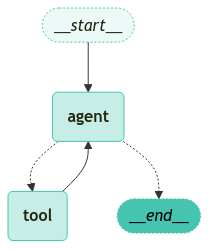

In [5]:
from graphs import visualize_graph

visualize_graph(app)

In [7]:
from langchain_core.messages import HumanMessage

# 스레드 ID가 1인 기본 설정 객체 초기화
config = {"configurable": {"thread_id": "1"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Coin입니다. 잘 부탁드립니다."
)

# 스트림 모드로 메시지 처리 및 응답 출력, 마지막 메시지의 상세 정보 표시
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Coin입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Coin님! 만나서 반갑습니다. 어떻게 도와드릴까요?


In [8]:
# 후속 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

# 스트림 모드로 두 번째 메시지 처리 및 응답 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Coin입니다! 도움이 필요하시면 언제든지 말씀해 주세요.


In [9]:
# 단계별 상태 확인
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

안녕하세요! 제 이름은 Coin입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Coin님! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Coin입니다! 도움이 필요하시면 언제든지 말씀해 주세요.


#### RemoveMessage 수정자를 사용하여 메시지 삭제

먼저 메시지를 수동으로 삭제하는 방법을 살펴보겠습니다. 현재 스레드의 상태를 확인해보겠습니다:

In [24]:
# 앱 상태에서 메시지 목록 추출 및 저장
messages = app.get_state(config).values["messages"]
messages

[AIMessage(content='안녕하세요, Coin님! 반갑습니다. 무엇을 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 59, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-39b5af7c-5bef-4cb4-97dc-d008f4421918-0', usage_metadata={'input_tokens': 59, 'output_tokens': 18, 'total_tokens': 77, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content='내 이름이 뭐라고요?', additional_kwargs={}, response_metadata={}, id='858aef6f-6bf0-46db-8f9b-e1ff957cc8ab'),
 AIMessage(content='당신의 이름은 Coin님입니다! 맞나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {

##### `update_state` 메서드를 사용하여 메시지 삭제합니다. 아이디를 넣어주면 Reducer가 찾아서 삭제하게 됩니다.

In [26]:
from langchain_core.messages import RemoveMessage

app.update_state(config, {"messages": [RemoveMessage(id=messages[0].id)]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb91f1-0f2a-6588-800b-535cf7e277e9'}}

messages 를 확인하여 첫번째 메시지가 삭제되었는지 확인합니다.

In [27]:
messages = app.get_state(config).values["messages"]
messages

[HumanMessage(content='내 이름이 뭐라고요?', additional_kwargs={}, response_metadata={}, id='858aef6f-6bf0-46db-8f9b-e1ff957cc8ab'),
 AIMessage(content='당신의 이름은 Coin님입니다! 맞나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 75, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-44781430-4bdd-4149-b654-c9e6c32a7a75-0', usage_metadata={'input_tokens': 75, 'output_tokens': 12, 'total_tokens': 87, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

#### 더 많은 메시지를 동적으로 삭제하는 방법입니다.

그래프 내부에서 프로그래밍 방식으로 메시지를 삭제할 수 있습니다.  
  
그래프 실행이 종료될때 오래된 메시지를 삭제하도록 그래프를 수정하는 방법입니다.  
  
3개 이전의 메시지를 삭제하는 방법입니다.

In [18]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import END


# 메시지 개수가 3개 초과 시 오래된 메시지 삭제 및 최신 메시지만 유지
def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# 메시지 상태에 따른 다음 실행 노드 결정 로직
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # 함수 호출이 없는 경우 메시지 삭제 함수 실행
    if not last_message.tool_calls:
        return "delete_messages"
    # 함수 호출이 있는 경우 액션 실행
    return "action"


# 메시지 상태 기반 워크플로우 그래프 정의
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# 메시지 삭제 노드 추가
workflow.add_node(delete_messages)

# 시작 노드에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 조건부 엣지 추가를 통한 노드 간 흐름 제어
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

# 액션 노드에서 에이전트 노드로 연결
workflow.add_edge("action", "agent")

# 메시지 삭제 노드에서 종료 노드로 연결
workflow.add_edge("delete_messages", END)

# 메모리 체크포인터를 사용하여 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)

그래프를 시각화합니다.

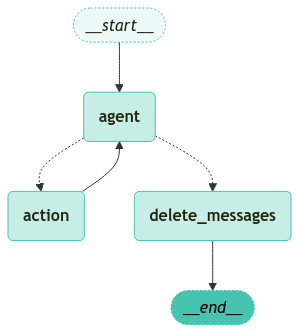

In [19]:
from graphs import visualize_graph

visualize_graph(app)

In [32]:
# LangChain 메시지 처리를 위한 HumanMessage 클래스 임포트
from langchain_core.messages import HumanMessage

# 스레드 ID가 포함된 설정 객체 초기화
config = {"configurable": {"thread_id": "3"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Coin입니다. 잘 부탁드립니다."
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', '안녕하세요! 제 이름은 Coin입니다. 잘 부탁드립니다.')]
[('human', '안녕하세요! 제 이름은 Coin입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Coin님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 이야기하고 싶은 주제가 있다면 말씀해 주세요!')]


In [33]:
# 2번째 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', '안녕하세요! 제 이름은 Coin입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Coin님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 이야기하고 싶은 주제가 있다면 말씀해 주세요!'), ('human', '내 이름이 뭐라고요?')]
[('human', '안녕하세요! 제 이름은 Coin입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Coin님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 이야기하고 싶은 주제가 있다면 말씀해 주세요!'), ('human', '내 이름이 뭐라고요?'), ('ai', '당신의 이름은 Coin입니다! 맞나요?')]
[('ai', '안녕하세요, Coin님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 이야기하고 싶은 주제가 있다면 말씀해 주세요!'), ('human', '내 이름이 뭐라고요?'), ('ai', '당신의 이름은 Coin입니다! 맞나요?')]


In [34]:
# 앱 상태에서 메시지 목록 추출 및 저장
messages = app.get_state(config).values["messages"]
# 메시지 목록 반환
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

안녕하세요, Coin님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 이야기하고 싶은 주제가 있다면 말씀해 주세요!
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Coin입니다! 맞나요?
